In [2]:
import rasterio
import matplotlib.pyplot as plt
from os import system
import IPython.display as disp
import time
from utils import *

In [11]:
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader

# from torchgeo.datamodules import InriaAerialImageLabelingDataModule
from torchgeo.datasets import CDL, Landsat7, Landsat8, Landsat9, VHR10, stack_samples, Sentinel
from torchgeo.samplers import RandomGeoSampler
# from torchgeo.trainers import SemanticSegmentationTask

In [12]:
import xarray as xr
import numpy as np

In [13]:
img_list = []
mask_list = []

### Importing LandSAT8 data - Downloaded from the USGS website

In [15]:
# landsat7 = Landsat7(root="", bands=["B1", ..., "B7"])
# iowa = Landsat8(root="..\\Data\\Remote Sensing\\LandSat\\Iowa", bands=["B1", "B2", "B3", "B4", "B5", "B6", "B7"])
kansas = Landsat9(root="..\\Data\\Remote Sensing\\LandSat\\Kansas_June", bands=["B1", "B2", "B3", "B4", "B5", "B6", "B7"])

In [16]:
cdl = CDL(root="..\\Data\\Remote Sensing\\CDL22")

In [17]:
dataset = cdl & (kansas)

Converting Landsat9 CRS from EPSG:32614 to EPSG:5070


In [18]:
count = 0

In [19]:
sampler = RandomGeoSampler(dataset, size=256, length=100)

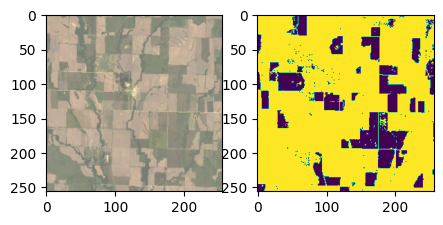

In [22]:

while(True):
    #clear screen
    disp.clear_output()
    sample = next(iter(sampler))
    datapoint = dataset[sample]

    mask = datapoint["mask"].numpy().transpose(1, 2, 0)
    mask[mask != 24] = 255

    img_7bands = datapoint["image"].numpy().transpose(1, 2, 0)
    ndvi = (img_7bands[:, :, 4] - img_7bands[:, :, 3]) / (img_7bands[:, :, 4] + img_7bands[:, :, 3])
    img_with_ndvi = np.dstack((img_7bands, ndvi))

    #show mask and image side by side
    img_rgb = img_with_ndvi[:, :, [3, 2, 1]]
    if (np.max(img_rgb) == 0):
        img_rgb = img_rgb
    else:
        img_rgb = img_rgb / np.max(img_rgb)

    fig, ax = plt.subplots(1, 2, figsize=(5, 5))
    ax[0].imshow(img_rgb)
    ax[1].imshow(mask)
    plt.show()

    user_input = input("Do you want to save the image? (y/n)")
    if (user_input == "y"):

        img_5_bands_ndvi = img_with_ndvi[:, :, [1, 2, 3, 4, 7]]
        # change mask to unsigned int 8
        mask = mask.astype(np.uint8)

        img_list.append(img_5_bands_ndvi)
        mask_list.append(mask)
        

        mask2 = mask_list[count].copy()
        im2 = img_list[count][:,:,[2,1,0]].copy()
        im2 = im2/np.max(im2)
        fig, ax = plt.subplots(1, 2, figsize=(5, 5))
        ax[0].imshow(im2)
        ax[1].imshow(mask2)
        plt.show()
        count += 1
        # wait for 2 seconds
        time.sleep(2)
    
    elif (user_input == "n"):
        continue

    elif (user_input == "q"):
        break



#sample block

In [23]:
# import json

# image_json = img_5_bands_ndvi.tolist()
# mask_json = mask.tolist()

# json_obj = {"image": image_json, "mask": mask_json}

# with open("kansas_jan.json", "w") as outfile:
#     json.dump(json_obj, outfile)

count

166

In [24]:
# # store image and mask as numpy array
np.save("kansas_june_image.npy", img_list)
np.save("kansas_june_mask.npy", mask_list)

In [26]:
loaded_img = np.load("kansas_june_image.npy")
loaded_mask = np.load("kansas_june_mask.npy")
print(loaded_img.shape)
print(loaded_mask.shape)

(166, 256, 256, 5)
(166, 256, 256, 1)


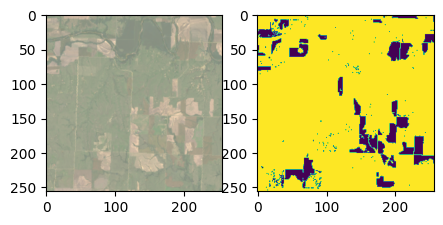

In [27]:

mask2 = loaded_mask[12].copy()
im2 = loaded_img[12][:,:,[2,1,0]].copy()
im2 = im2/np.max(im2)
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(im2)
ax[1].imshow(mask2)
plt.show()

In [28]:
# map loaded_mask to remove noise
for i in range(len(loaded_mask)):
    loaded_mask[i] = remove_noise(loaded_mask[i])


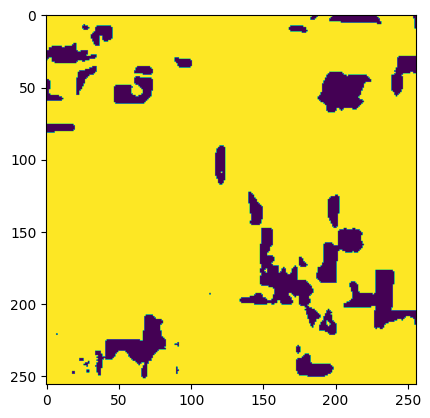

In [29]:
plt.imshow(loaded_mask[12])

In [30]:
np.save("kansas_june_mask_denoised.npy", loaded_mask)